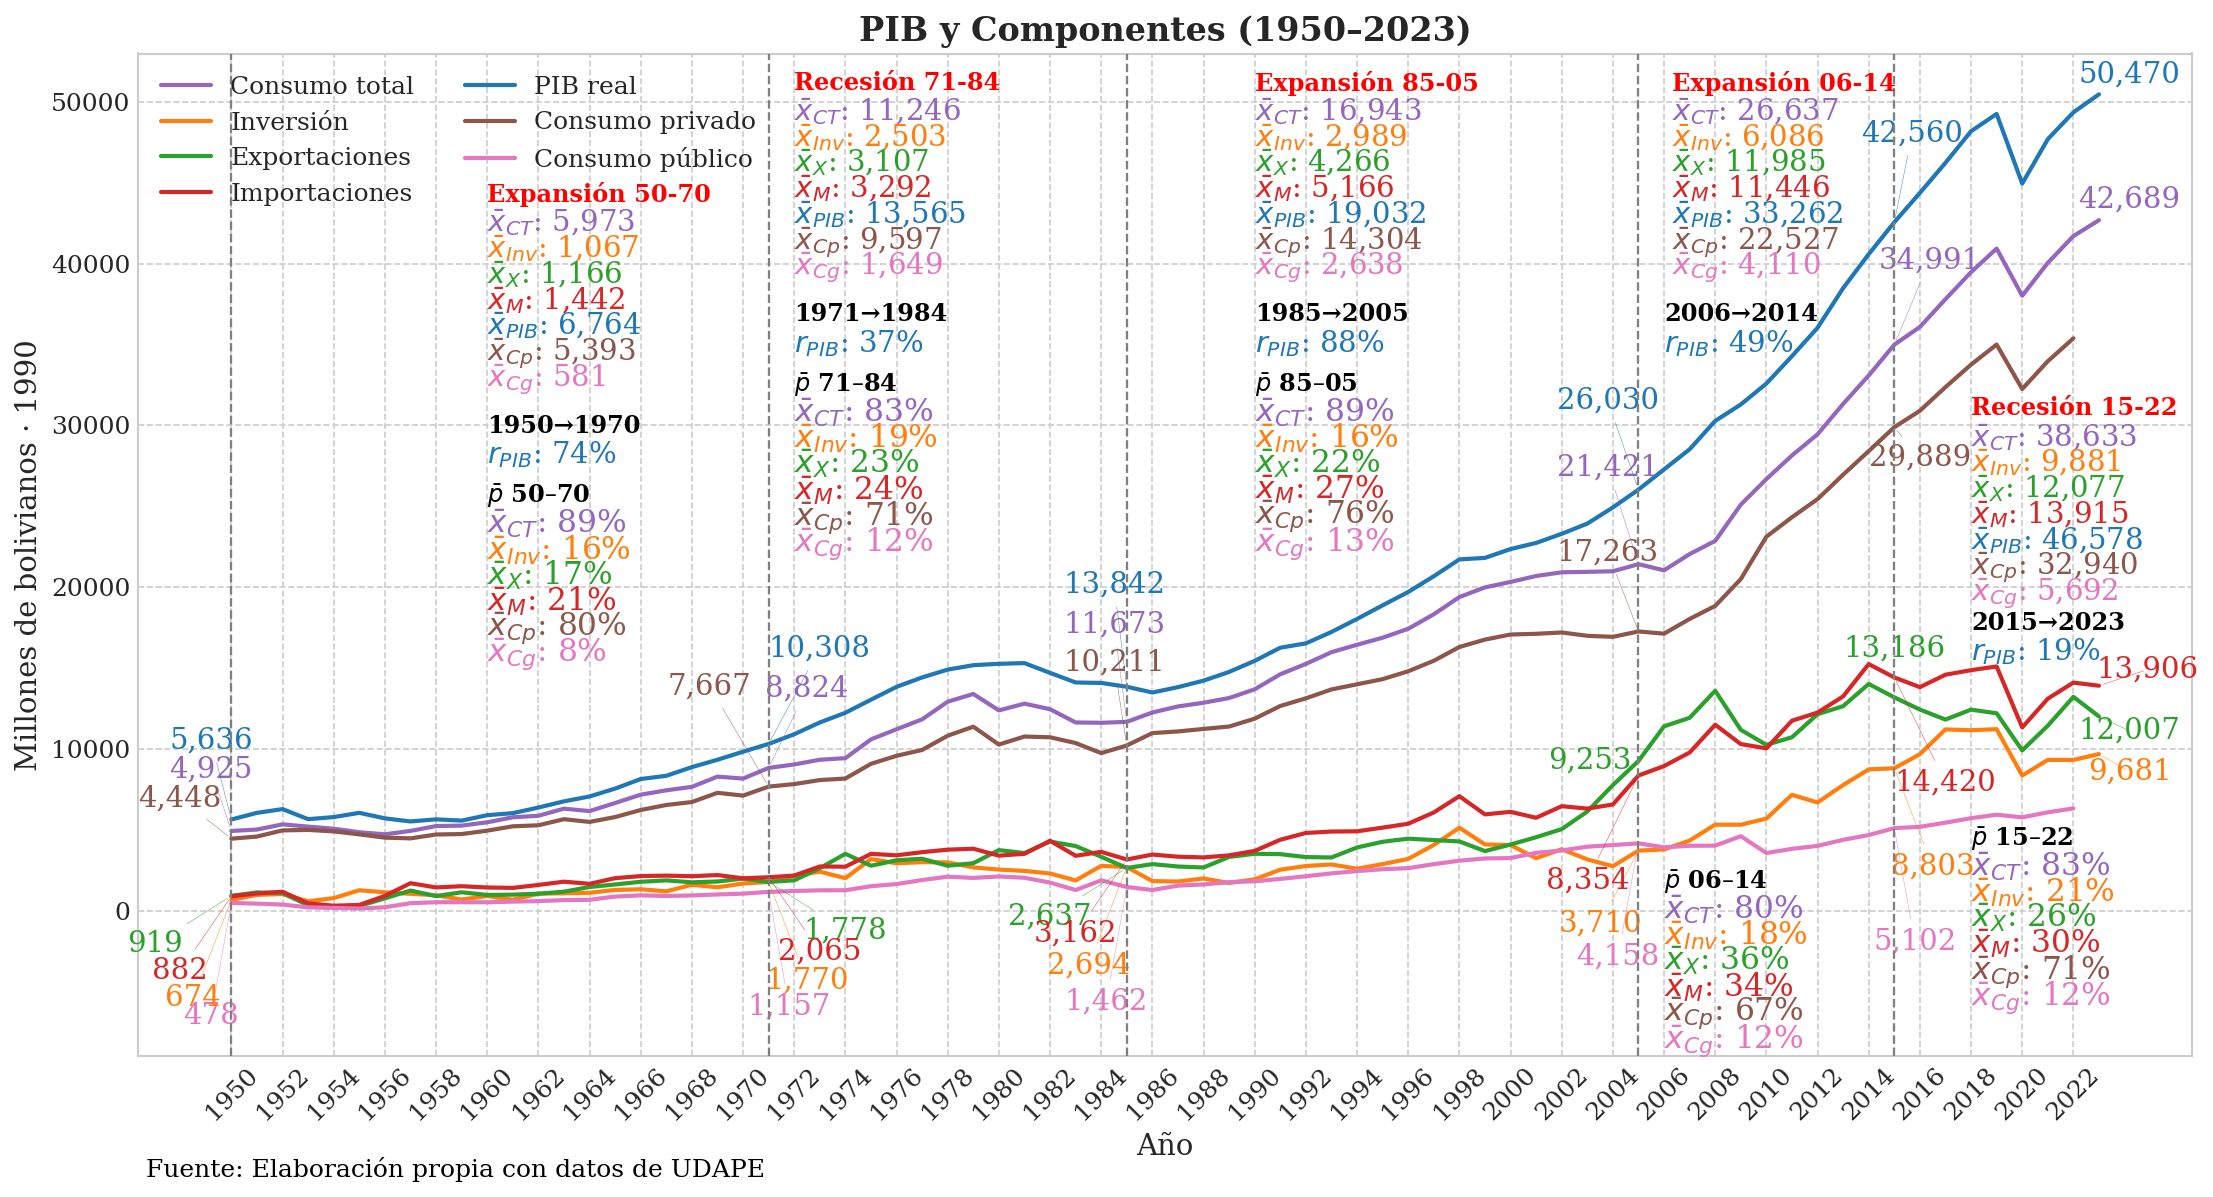

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
import sys
sys.path.append(os.path.abspath('../'))          # utilidades propias
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi,
    add_participation_cycle_boxes
)
from config import *

# ── 1. Configuración general y salida ────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif','font.size':12,
    'axes.titlesize':16,'axes.labelsize':14,
    'grid.linestyle':'--','lines.linewidth':2,
    'figure.dpi':150,'savefig.bbox':'tight'
})
component_colors = {
    'pib_real_base_1990': '#1f77b4'
}
# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = pd.read_sql("SELECT * FROM pib_real_gasto", conn, index_col='año') / 1000

# ── 3. Componentes y estadísticas ───────────────────────────────────
componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real"),
    ("consumo_privado",              "Consumo privado"),
    ("consumo_publico",              "Consumo público"),
]
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in CYCLES_SIN_CRISIS.items()
}

# ── 4. Configuración de hitos y anotaciones ────────────────────────
# Años donde dibujaremos líneas verticales
hitos_v = {
    1950: "Expansion",
    1971: "Recesion",
    1985: "Expansion",
    2005: "Expansion",
    2015: "Recesion"
}

# Años que queremos anotar en todas las series
anot_years = [1950,1971,1985, 2005, 2015, 2023]

# ── Offsets personalizados para cada componente y año ──────────────
annotation_offsets = {
    'gastos_consumo': {
        1950: (-0.8,  3800), 1971: (1.5, 4900), 1985: (-0.5,  6000),
        2005: (-1.2,  6000), 2015: (1.38,   5200),2023: (1.2, 1300),
    },
    'formacion_capital': {
        1950: (-1.5, -6100), 1971: (1.5, -6100), 1985: (-1.5,  -6100),
        2005: (-1.5,  -4500), 2015: (1.5,  -6100), 2023: (1.2, -1100),
    },
    'exportacion_bienes_servicios': {
        1950: (-3,  -3000), 1971: (3, -3000), 1985: (-3, -3000),
        2005: (-1.9,    0), 2015: (0,   3000),2023: (1.2, -900),
    },
    'importacion_bienes': {
        1950: (-2, -4600), 1971: (2, -4600), 1985: (-2, -4600),
        2005: (-2, -6500), 2015: (2,   -6500),2023: (1.9, 1000),
    },
    'pib_real_base_1990': {
        1950: (-0.8,  4900), 1971: (2, 5900), 1985: (-0.5,  6300),
        2005: (-1.2,  5500), 2015: (0.7,    5500),2023: (1.2, 1200),
    },
    'consumo_privado': {
        1950: (-2, 2500), 1971: (-2.3, 6200), 1985: (-0.5,  5100),
        2005: (-1.2,  4900), 2015: (1,   -1900),2023: (1.2,  800),
    },
    'consumo_publico': {
        1950: (-0.8, -7000), 1971: (0.8, -7100), 1985: (-0.8,  -7100),
        2005: (-0.8, -7000), 2015: (0.8,    -7000),2023: (1.2,  600)
    },
}
hitos_offset = {
    1950: 0.45, 1971: 0.5, 1985: 0.5,
    2005: 0.70, 2015: 0.55,
}
text_offsets = {
    "Expansión 50-70": (1960, 0.85),
    "Recesión 71-84":  (1972, 0.98),
    "Expansión 85-05": (1990, 0.98),
    "Expansión 06-14": (2006.3, 0.98),
    "Recesión 15-22":  (2018, 0.6),
}

period_offsets: dict[str, tuple[float, float]] = {
    '1950-1970': (1960, 0.58),
    '1971-1984': (1972, 0.71),
    '1985-2005': (1990, 0.71),
    '2006-2014': (2006, 0.71),
    '2015-2023': (2018, 0.35),
}
participation_offsets = {
    "1950-1970": (1960, 0.50),
    "1971-1984": (1972, 0.63),
    "1985-2005": (1990, 0.63),
    "2006-2014": (2006, 0.05),
    "2015-2022": (2018, 0.1),
}
# ── 8.4 Ubicación de cuadros dentro de la gráfica ─────────────────────────

cmap = plt.get_cmap("tab10")

component_colors = {
    "gastos_consumo":               cmap(4),  # azul     → CT  
    "formacion_capital":            cmap(1),  # naranja  → Inv  
    "exportacion_bienes_servicios": cmap(2),  # verde    → X  
    "importacion_bienes":           cmap(3),  # rojo     → M  
    "pib_real_base_1990":           cmap(0),  # morado   → PIB  
    "consumo_privado":              cmap(5),  # marrón   → Cp  
    "consumo_publico":              cmap(6),  # rosa     → Cg  
}
# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))

for i,(col,label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=component_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset)
#7 anotaciones
add_year_value_annotations(
    ax,
    df,
    years=anot_years,
    columnas=[col for col, _ in componentes],
    annotation_offsets=annotation_offsets,
    colors=component_colors,
    arrow_lw=0.2
)

# Mapa de tasas por año final
periodos_tasas = [
    (1950, 1970),
    (1971, 1984),
    (1985, 2005),
    (2006, 2014),
    (2015, 2023),
]
periodos_participacion = [
    (1950, 1970),
    (1971, 1984),
    (1985, 2005),
    (2006, 2014),
    (2015, 2022),
]



# ── 8.1 Diccionario de abreviaturas ─────────────────────────────────────
abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

add_period_growth_annotations_multi(
    ax, df, periodos_tasas,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)





# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr_map=abbr,
    colors=component_colors,
    line_spacing=line_spacing
)
add_participation_cycle_boxes(
    ax,
    df,
    periodos_participacion,
    [ 'gastos_consumo', 'formacion_capital', 'exportacion_bienes_servicios', 'importacion_bienes', 'consumo_privado', 'consumo_publico'],
    'pib_real_base_1990',
    participation_offsets,
    abbr,
    component_colors,
)
# ── 9. Formato final ────────────────────────────────────────────────
ax.set_title(f"PIB y Componentes ({df.index[0]}–{df.index[-1]})", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(-9000, df.max().max() * 1.05)

fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_1.png"))
plt.show()



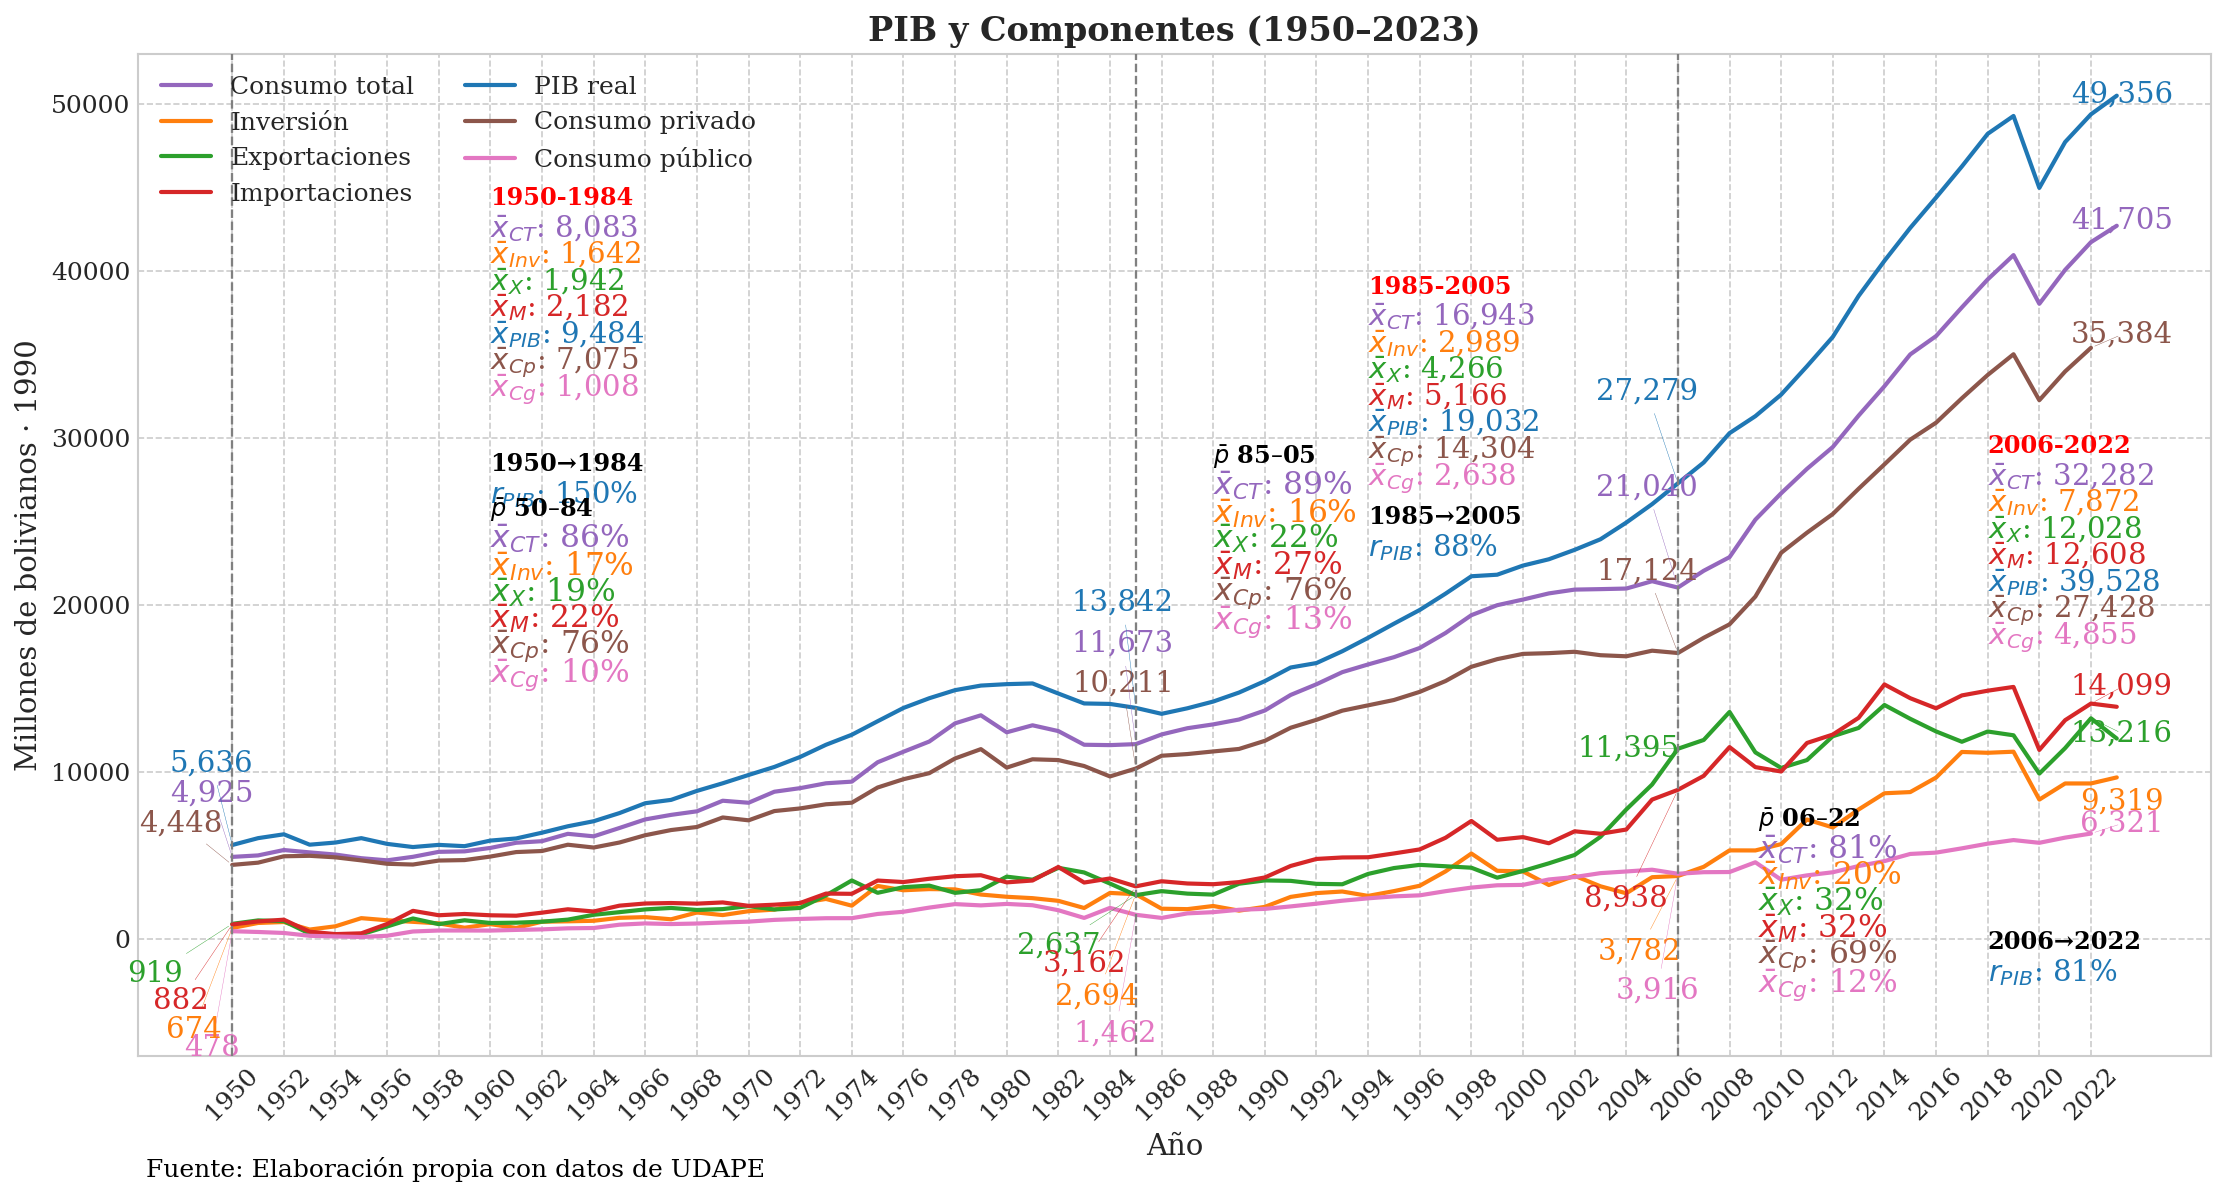

In [57]:
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in CYCLES_PERIODOS.items()
}
# ── 4. Configuración de hitos y anotaciones ────────────────────────
# Años donde dibujaremos líneas verticales
hitos_v = {
    1950: "1950-1984",
    1985: "1985-2005",
    2006: "2006-2023",
}

# Años que queremos anotar en todas las series
anot_years = [1950,1985,2006,2022]

# ── Offsets personalizados para cada componente y año ──────────────
annotation_offsets = {
    "gastos_consumo": {
        1950: (-0.8,  3800),
        1985: (-0.5,  6000),
        2006: (-1.2,  6000),   # mismo offset que en 2005
        2022: (1.2,   1300),   # mismo offset que en 2023
    },
    "formacion_capital": {
        1950: (-1.5, -6100),
        1985: (-1.5, -6100),
        2006: (-1.5, -4500),   # mismo offset que en 2005
        2022: (1.2,  -1100),   # mismo offset que en 2023
    },
    "exportacion_bienes_servicios": {
        1950: (-3,   -3000),
        1985: (-3,   -3000),
        2006: (-1.9,     0),   # mismo offset que en 2005
        2022: (1.2,   -900),   # mismo offset que en 2023
    },
    "importacion_bienes": {
        1950: (-2,   -4600),
        1985: (-2,   -4600),
        2006: (-2,   -6500),   # mismo offset que en 2005
        2022: (1.2,   1000),   # mismo offset que en 2023
    },
    "pib_real_base_1990": {
        1950: (-0.8,  4900),
        1985: (-0.5,  6300),
        2006: (-1.2,  5500),   # mismo offset que en 2005
        2022: (1.2,   1200),   # mismo offset que en 2023
    },
    "consumo_privado": {
        1950: (-2,    2500),
        1985: (-0.5,  5100),
        2006: (-1.2,  4900),   # mismo offset que en 2005
        2022: (1.2,    800),   # mismo offset que en 2023
    },
    "consumo_publico": {
        1950: (-0.8, -7000),
        1985: (-0.8, -7100),
        2006: (-0.8, -7000),   # mismo offset que en 2005
        2022: (1.2,    600),   # mismo offset que en 2023
    },
}
hitos_offset = {
    1950: 0.45, 1985: 0.5, 2006: 0.5,
    2022: 0.70,
}
text_offsets = {
    "1950-1984": (1960, 0.85),
    "1985-2005":  (1994, 0.75),
    "2006-2022": (2018, 0.57),
}
period_offsets: dict[str, tuple[float, float]] = {
    '1950-1984': (1960, 0.55),
    '1985-2005': (1994, 0.49),
    '2006-2022': (2018, 0.01),
}
participation_offsets = {
    "1950-1984": (1960, 0.50),
    "1985-2005": (1988, 0.56),
    "2006-2022": (2009.1, 0.15),
}
# ── 8.4 Ubicación de cuadros dentro de la gráfica ─────────────────────────

cmap = plt.get_cmap("tab10")

component_colors = {
    "gastos_consumo":               cmap(4),  # azul     → CT  
    "formacion_capital":            cmap(1),  # naranja  → Inv  
    "exportacion_bienes_servicios": cmap(2),  # verde    → X  
    "importacion_bienes":           cmap(3),  # rojo     → M  
    "pib_real_base_1990":           cmap(0),  # morado   → PIB  
    "consumo_privado":              cmap(5),  # marrón   → Cp  
    "consumo_publico":              cmap(6),  # rosa     → Cg  
}
# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))

for i,(col,label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=component_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset)
#7 anotaciones
add_year_value_annotations(
    ax,
    df,
    years=anot_years,
    columnas=[col for col, _ in componentes],
    annotation_offsets=annotation_offsets,
    colors=component_colors,
    arrow_lw=0.2
)






# ── 8.1 Diccionario de abreviaturas ─────────────────────────────────────
abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

add_period_growth_annotations_multi(
    ax, df, periodos_tasas_periodos,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)


# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr_map=abbr,
    colors=component_colors,
    line_spacing=line_spacing
)
periodos_participacion = [
    (1950, 1984),
    (1985, 2005),
    (2006, 2022),
]
add_participation_cycle_boxes(
    ax,
    df,
    periodos_participacion,
    [ 'gastos_consumo', 'formacion_capital', 'exportacion_bienes_servicios', 'importacion_bienes', 'consumo_privado', 'consumo_publico'],
    'pib_real_base_1990',
    participation_offsets,
    abbr,
    component_colors,
)

# ── 9. Formato final ────────────────────────────────────────────────
ax.set_title(f"PIB y Componentes ({df.index[0]}–{df.index[-1]})", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(-7000, df.max().max() * 1.05)

fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_2.png"))
plt.show()

